In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='qZ90huf-lCOBezTUA95TxrzdyTyJNv3hnOdZrtcX3xSH',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'powersystemfaultdetection-donotdelete-pr-wftoemw52oss0f'
object_key = 'fault_data.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_1 = pd.read_csv(body)
df_1.head(10)


,Fault ID,Fault Type,"Fault Location (Latitude, Longitude)",Voltage (V),Current (A),Power Load (MW),Temperature (°C),Wind Speed (km/h),Weather Condition,Maintenance Status,Component Health,Duration of Fault (hrs),Down time (hrs)
0,F001,Line Breakage,"(34.0522, -118.2437)",2200,250,50,25,20,Clear,Scheduled,Normal,2.0,1.0
1,F002,Transformer Failure,"(34.056, -118.245)",1800,180,45,28,15,Rainy,Completed,Faulty,3.0,5.0
2,F003,Overheating,"(34.0525, -118.244)",2100,230,55,35,25,Windstorm,Pending,Overheated,4.0,6.0
3,F004,Line Breakage,"(34.055, -118.242)",2050,240,48,23,10,Clear,Completed,Normal,2.5,3.0
4,F005,Transformer Failure,"(34.0545, -118.243)",1900,190,50,30,18,Snowy,Scheduled,Faulty,3.5,4.0
5,F006,Overheating,"(34.05, -118.24)",2150,220,52,32,22,Thunderstorm,Pending,Overheated,5.0,7.0
6,F007,Line Breakage,"(34.9449, -118.9839)",1994,233,51,23,21,Snowy,Completed,Normal,3.7,6.1
7,F008,Transformer Failure,"(34.2294, -118.2988)",2133,229,52,20,18,Snowy,Scheduled,Normal,5.4,2.1
8,F009,Line Breakage,"(34.1279, -118.8442)",2155,240,45,21,29,Rainy,Pending,Overheated,3.2,4.7
9,F010,Line Breakage,"(34.4192, -118.8254)",2065,199,55,25,21,Clear,Scheduled,Normal,4.0,2.8


In [3]:

# Show DataFrame structure
print(df_1.info())

# Check for missing values
print("\nMissing values:\n", df_1.isnull().sum())

# Check unique fault types (use the correct column name)
print("\nUnique fault classes:\n", df_1['Fault Type'].unique())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Fault ID                              506 non-null    object 
 1   Fault Type                            506 non-null    object 
 2   Fault Location (Latitude, Longitude)  506 non-null    object 
 3   Voltage (V)                           506 non-null    int64  
 4   Current (A)                           506 non-null    int64  
 5   Power Load (MW)                       506 non-null    int64  
 6   Temperature (°C)                      506 non-null    int64  
 7   Wind Speed (km/h)                     506 non-null    int64  
 8   Weather Condition                     506 non-null    object 
 9   Maintenance Status                    506 non-null    object 
 10  Component Health                      506 non-null    object 
 11  Duration of Fault (

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_1['Fault Type Encoded'] = le.fit_transform(df_1['Fault Type'])
print(df_1[['Fault Type', 'Fault Type Encoded']].head())


            Fault Type  Fault Type Encoded
0        Line Breakage                   0
1  Transformer Failure                   2
2          Overheating                   1
3        Line Breakage                   0
4  Transformer Failure                   2


In [5]:
X = df_1.drop(['Fault ID', 'Fault Type', 'Fault Type Encoded'], axis=1)
y = df_1['Fault Type Encoded']

# Optional: convert object/string columns to numeric (via one-hot encoding)
X = pd.get_dummies(X)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.3333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.24      0.25        34
           1       0.34      0.38      0.36        34
           2       0.37      0.38      0.38        34

    accuracy                           0.33       102
   macro avg       0.33      0.33      0.33       102
weighted avg       0.33      0.33      0.33       102



In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Drop non-numeric or non-useful columns
df_cleaned = df_1.drop(['Fault ID', 'Fault Location (Latitude, Longitude)'], axis=1)

# Step 2: Encode categorical columns
le = LabelEncoder()
df_cleaned['Fault Type'] = le.fit_transform(df_cleaned['Fault Type'])
df_cleaned['Weather Condition'] = le.fit_transform(df_cleaned['Weather Condition'])
df_cleaned['Maintenance Status'] = le.fit_transform(df_cleaned['Maintenance Status'])
df_cleaned['Component Health'] = le.fit_transform(df_cleaned['Component Health'])

# Step 3: Split features and target
X = df_cleaned.drop('Fault Type', axis=1)
y = df_cleaned['Fault Type']

# Step 4: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Train Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 7: Evaluate
y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


✅ Accuracy: 1.0

📊 Classification Report:
               precision    recall  f1-score   support

      Faulty       1.00      1.00      1.00        34
      Normal       1.00      1.00      1.00        34
  Overheated       1.00      1.00      1.00        34

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102



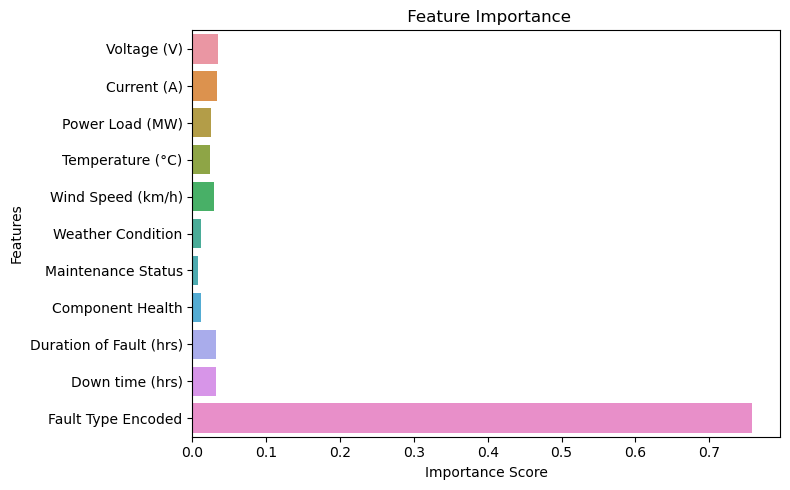

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title(" Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


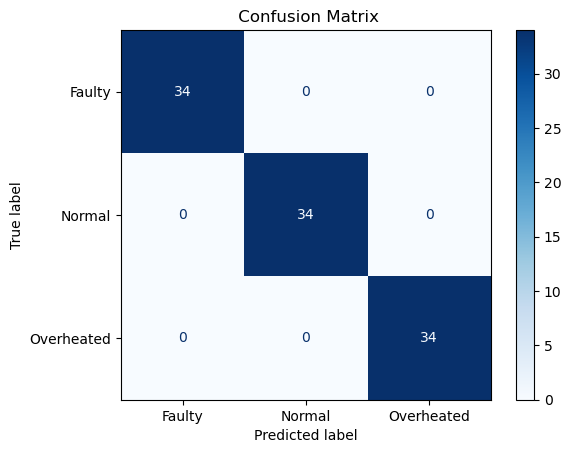

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title(" Confusion Matrix")
plt.show()
